<a href="https://colab.research.google.com/github/thanit456/NeuroSummary/blob/master/tf2_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split


import pickle
import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
mpl.rc('font', family='TH Sarabun New')

plt.rcParams['font.family']='TH Sarabun New'  
%matplotlib inline

--2020-05-19 20:11:34--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2020-05-19 20:11:34--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf.4’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.02s   

2020-05-19 20:11:34 (5.25 MB/s) - ‘

# My own data preparation

In [0]:
with open('/content/drive/Shared drives/NeuroSummary/data/b_data_playground/thai_gov_split/train_v2.pkl', 'rb') as f:
  train_set = pickle.load(f)

with open('/content/drive/Shared drives/NeuroSummary/data/b_data_playground/thai_gov_split/val_v2.pkl', 'rb') as f:
  val_set = pickle.load(f)

with open('/content/drive/Shared drives/NeuroSummary/data/b_data_playground/thai_gov_split/test_v2.pkl', 'rb') as f:
  test_set = pickle.load(f)

In [0]:
train_set.head()

,content,headline,class
11629,"[กระทรวงทรัพยากรธรรมชาติ, และสิ่ง, แวดล้อม, โด...","[ทส., จัด, การ, ประชุม, การ, ลด, ปริมาณ, ขยะ, ...",ด้านความมั่นคง
8470,"[วัน, นี้, 28, มิถุนายน, 2560, เวลา, 11, ., 30...","[นายก, รัฐมนตรี, เผย, ต้องการ, ให้, การ, เปลี่...",ข่าวทำเนียบรัฐบาล
6389,"[เมื่อ, วัน, จันทร์, ที่, 9, กรกฎาคม, 2561, เว...","[ม.ล.ปนัดดาฯ, กล่าว, สุนทรพจน์, ใน, พิธี, เปิด...",ด้านกฎหมายฯ
1058,"[รอง, ปลัด, กระทรวงดิจิทัลฯ, นางวรรณพร เทพหัสด...","[รอง, ปลัด, กระทรวงดิจิทัลฯ, เปิด, งาน, การ, พ...",ด้านสังคม
6155,"[รัฐบาล, เร่งรัด, ขับ, เคลื่อน, งาน, สำคัญ, เพ...","[เร่ง, เดินหน้า, 5, โครงการ, ลด, ความ, เหลื่อม...",รายการวิทยุไทยคู่ฟ้า


In [0]:
## ! use only n first words for headline generation
def use_firt_n_words(df_content, n):
  new_ls = []
  for content in df_content:
    new_ls.append(['<s>'] + content[:n] + ['</s>'])
  return new_ls

#define_n_first_words
n_first_content = 50
n_first_headline = 20

#trim sentence
words_train_contents = use_firt_n_words(train_set['content'], n=n_first_content)
words_train_headlines = use_firt_n_words(train_set['headline'], n=n_first_headline)
words_val_contents = use_firt_n_words(val_set['content'], n=n_first_content)
words_val_headlines = use_firt_n_words(val_set['headline'], n=n_first_headline)
words_test_contents = use_firt_n_words(test_set['content'], n=n_first_content)
words_test_headlines = use_firt_n_words(test_set['headline'], n=n_first_headline)

# generate gold_sum
gold_sum_train = list(map(lambda x: " ".join(x),words_train_headlines))
gold_sum_val = list(map(lambda x: " ".join(x),words_val_headlines))
gold_sum_test = list(map(lambda x: " ".join(x),words_test_headlines))

In [0]:
import collections
def create_index(input_data,threshold):
    input_text = [data for data in input_data]
    # counts of word type has to be above or equal threshold
    words = [word for sublist in input_text for word in sublist]
    print("words :",words)
    word_count_all = list()
    word_count = list()
    #use set and len to get the number of unique words
    word_count_all.extend(collections.Counter(words).most_common(len(set(words))))
    unkcnt = 0
    for (word,cnt) in word_count_all:
      if cnt >= threshold:
        word_count.append((word,cnt))
      else:
        unkcnt+=cnt
    #include a token for unknown word
    word_count.append(("UNK",unkcnt))
    #print out 10 most frequent words
    # print("top 10: ",word_count[:10])
    # print("bottom 10: ",word_count[-10:])
    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
      dictionary[word[0]] = len(dictionary)
    # dictionary['<s>'] = len(dictionary) 
    # dictionary['</s>'] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return dictionary, reverse_dictionary
dict_t, rev_dict_t = create_index(input_data=words_train_contents+words_train_headlines,threshold=0)
# dict_stop_t, rev_dict_stop_t = create_index(input_data=words_70_train_stop_contents+words_20_train_stop_headlines,threshold=0)
print('Vocab size (Content): ',len(dict_t))
# print('Vocab stop ?size (Content): ',len(dict_stop_t))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Vocab size (Content):  25313


In [0]:
def convert(input_data,dictionary) :
  X = list()
  for data in input_data:
    sub_data = []
    for word in data:
      if word in dictionary:
        sub_data.append(dictionary[word])
      else:
        sub_data.append(dictionary["UNK"])
    X.append(sub_data)
  return np.array(X)

In [0]:
X_train = convert(words_train_contents,dict_t)
y_train = convert(words_train_headlines,dict_t)
X_val = convert(words_val_contents,dict_t)
y_val = convert(words_val_headlines,dict_t)
X_test = convert(words_test_contents,dict_t)
y_test = convert(words_test_headlines,dict_t)

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen_input = 50
maxlen_output = 20

X_train = pad_sequences(X_train, maxlen=maxlen_input, padding='post')
y_train = pad_sequences(y_train, maxlen=maxlen_output, padding='post')
X_val = pad_sequences(X_val, maxlen=maxlen_input, padding='post')
y_val = pad_sequences(y_val, maxlen=maxlen_output, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen_input, padding='post')
y_test = pad_sequences(y_test, maxlen=maxlen_output, padding='post')

# TF 2.0 data preparation

In [0]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
VAL_BUFFER_SIZE = len(X_val)
steps_per_epoch = len(X_train)//BATCH_SIZE
val_steps_per_epoch = len(X_val)//VAL_BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(dict_t)
vocab_tar_size = len(dict_t)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(VAL_BATCH_SIZE, drop_remainder=True)

In [0]:
val_example_input_batch, val_example_target_batch = next(iter(val_dataset))
val_example_input_batch.shape, val_example_target_batch.shape

(TensorShape([64, 50]), TensorShape([64, 20]))

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 50]), TensorShape([64, 20]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
print(vocab_inp_size)
print(embedding_dim)
print(units)
print(BATCH_SIZE)

25313
256
1024
64


In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 50, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
# sample input
sample_hidden = encoder.initialize_hidden_state()
print(sample_hidden.shape)
print(example_input_batch.shape)

(64, 1024)
(64, 50)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
attention_layer = BahdanauAttention(20)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 50, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 25313)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints_scheduled_sampling'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Teacher forcing

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([dict_t['<s>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

@tf.function
def val_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([dict_t['<s>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss


In [0]:
from tqdm import tqdm_notebook
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()


  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_total_loss = 0


  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 50 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  for (batch, (val_inp, val_targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss = val_step(val_inp, val_targ, enc_hidden)
    val_total_loss += val_batch_loss
  
  # saving (checkpoint) the model every 10 epochs
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch), end=', ')
  print('Val loss {:.4f}'.format(val_total_loss / val_steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Scheduled sampling


In [0]:
@tf.function
def train_step(inp, targ, enc_hidden, it):
  loss = 0
  epsilon = 0.9999999
  k = 3
  c = 0.1


  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([dict_t['<s>']] * BATCH_SIZE, 1)

    eps = tf.math.maximum(epsilon, k-c*it)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      _x = tf.random.uniform(shape=[], minval=0,maxval=1)
      if _x < eps:
        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)
      else:
        # dont use teacher forcing
        # print(predictions)
        # print(tf.math.argmax(predictions, axis=1))
        dec_input = tf.cast(tf.expand_dims(tf.math.argmax(predictions, axis=1), 1), dtype=tf.int32)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

@tf.function
def val_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([dict_t['<s>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss


In [0]:
from tqdm import tqdm_notebook
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()


  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_total_loss = 0


  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    batch_loss = train_step(inp, targ, enc_hidden, epoch)
    total_loss += batch_loss

    if batch % 50 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  for (batch, (val_inp, val_targ)) in enumerate(val_dataset.take(val_steps_per_epoch)):
    val_batch_loss = val_step(val_inp, val_targ, enc_hidden)
    val_total_loss += val_batch_loss
  
  # saving (checkpoint) the model every 10 epochs
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch), end=', ')
  print('Val loss {:.4f}'.format(val_total_loss / val_steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.1588
Epoch 1 Batch 50 Loss 5.7090
Epoch 1 Batch 100 Loss 5.4567
Epoch 1 Batch 150 Loss 5.5036
Epoch 1 Loss 5.6833, Val loss 5.4745
Time taken for 1 epoch 85.2891309261322 sec

Epoch 2 Batch 0 Loss 5.3380
Epoch 2 Batch 50 Loss 4.9778
Epoch 2 Batch 100 Loss 4.8725
Epoch 2 Batch 150 Loss 4.7886
Epoch 2 Loss 5.0528, Val loss 4.7663
Time taken for 1 epoch 61.56448531150818 sec

Epoch 3 Batch 0 Loss 4.2595
Epoch 3 Batch 50 Loss 4.4805
Epoch 3 Batch 100 Loss 4.4802
Epoch 3 Batch 150 Loss 4.1096
Epoch 3 Loss 4.3575, Val loss 4.3397
Time taken for 1 epoch 62.042478799819946 sec

Epoch 4 Batch 0 Loss 4.0784
Epoch 4 Batch 50 Loss 3.9081
Epoch 4 Batch 100 Loss 3.9292
Epoch 4 Batch 150 Loss 3.6772
Epoch 4 Loss 3.8807, Val loss 4.0960
Time taken for 1 epoch 62.008618116378784 sec

Epoch 5 Batch 0 Loss 3.7025
Epoch 5 Batch 50 Loss 3.2536
Epoch 5 Batch 100 Loss 3.1784
Epoch 5 Batch 150 Loss 3.3773
Epoch 5 Loss 3.4919, Val loss 3.9394
Time taken for 1 epoch 61.29388499259949 sec


# Generation

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((maxlen_output, maxlen_input))

  inputs = sentence.reshape(1, maxlen_input)
  # sentence = preprocess_sentence(sentence)

  # inputs = [rev_dict_t[i] for i in sentence.split(' ')]
  # inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
  #                                                        maxlen=max_length_inp,
  #                                                        padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = '<s> '

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([dict_t['<s>']], 0)

  for t in range(maxlen_output):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += rev_dict_t[predicted_id] + ' '

    if rev_dict_t[predicted_id] == '</s>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
   
  plt.show()

In [0]:
import seaborn as sns
def index2sentence(indexes):
  result = ''
  for i, index in enumerate(indexes):
    result += rev_dict_t[index] + ' '

    if rev_dict_t[index] == '</s>':
      return result
    
  return result

def translate(sentence, plot=True):
  result, sentence, attention_plot = evaluate(sentence)

  if not plot:
    return result

  print('Input: %s' % (sentence))
  print('prediction : {}'.format(result))
  
  
  sentence = index2sentence(sentence)
  
  if plot:
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    # plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    plt.figure(figsize=(20,10))
    sns.heatmap(attention_plot, yticklabels = result.split(' '), xticklabels = sentence.split(' '), linewidths=0.01)
    plt.show()

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
X_test[0].shape

(50,)

In [0]:
print('headline : ',index2sentence(y_test[0]))
print('content  : ',index2sentence(X_test[0]))

headline :  <s> สคบ. ชี้แจง กรณี ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK </s> 
content  :  วัน ที่ 7 ก.ย. 2561 พลตำรวจตรี ประสิทธิ์ เฉลิมวุฒิศักดิ์ เลขาธิการ คณะ กรรมการคุ้มครอง ผู้ บริโภค สำนักงานคณะกรรมการคุ้มครอง ผู้ บริโภค ชี้แจง ประเด็น ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK UNK จาก กรณี UNK อายุ 56 ปี ชาว บ้าน UNK จ.ขอนแก่น ร้องเรียน ต่อ สื่อ มวล ชน เกี่ยว กับ ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK ที่ มี พนักงาน ขาย นำ </s> 


Input: [    8     4   232   532    25 11519   226    32  2419    10   578  8225
    10   578   166   319   405   727   389   121 25312 25312    41   153
 25312   673  2876    28   288   219 25312  2111  1040    96   347   574
   511   357    35   405   727   389   121 25312     4    19   867   461
    63     3]
prediction : <s> สำนักงานนโยบายและแผนทรัพยากรธรรมชาติ และสิ่ง แวดล้อม ชี้แจง กรณี การ ยางแห่งประเทศไทย ชี้แจง กรณี การ ยางแห่งประเทศไทย ชี้แจง กรณี การ ยางแห่งประเทศไทย ชี้แจง กรณี การ ยางแห่งประเทศไทย ชี้แจง 


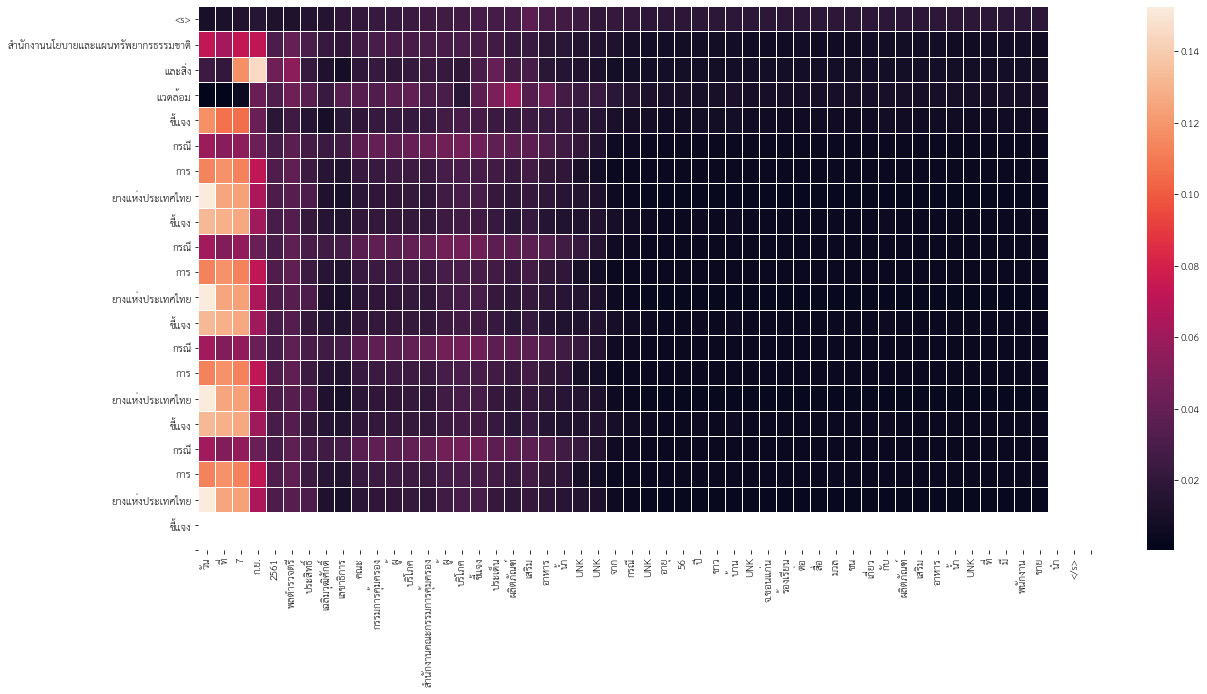

In [0]:
translate(X_test[0])

headline  :  <s> สคบ. ชี้แจง กรณี ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK </s> 
content   :  วัน ที่ 7 ก.ย. 2561 พลตำรวจตรี ประสิทธิ์ เฉลิมวุฒิศักดิ์ เลขาธิการ คณะ กรรมการคุ้มครอง ผู้ บริโภค สำนักงานคณะกรรมการคุ้มครอง ผู้ บริโภค ชี้แจง ประเด็น ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK UNK จาก กรณี UNK อายุ 56 ปี ชาว บ้าน UNK จ.ขอนแก่น ร้องเรียน ต่อ สื่อ มวล ชน เกี่ยว กับ ผลิตภัณฑ์ เสริม อาหาร น้ำ UNK ที่ มี พนักงาน ขาย นำ </s> 
Input: [    8     4   232   532    25 11519   226    32  2419    10   578  8225
    10   578   166   319   405   727   389   121 25312 25312    41   153
 25312   673  2876    28   288   219 25312  2111  1040    96   347   574
   511   357    35   405   727   389   121 25312     4    19   867   461
    63     3]
prediction : <s> สำนักงานนโยบายและแผนทรัพยากรธรรมชาติ และสิ่ง แวดล้อม ชี้แจง กรณี การ ยางแห่งประเทศไทย ชี้แจง กรณี การ ยางแห่งประเทศไทย ชี้แจง กรณี การ ยางแห่งประเทศไทย ชี้แจง กรณี การ ยางแห่งประเทศไทย ชี้แจง 


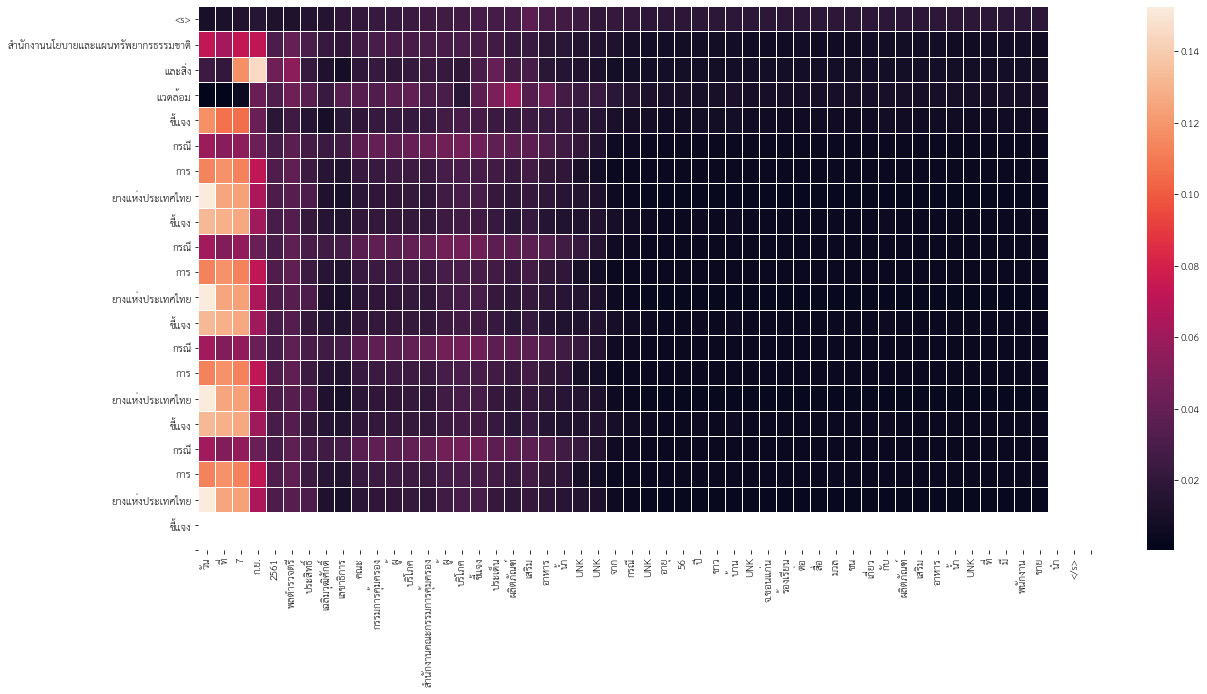

######################################################################################################################################################
headline  :  ตรวจ ราชการ กระทรวงอุตสาหกรรม ลง พื้นที่ ตรวจ ราชการ รอบ 2 ประจำ ปี งบ ประมาณ พ.ศ. 2561 ใน เขต พื้นที่ รับผิดชอบ </s> 
content   :  วัน ที่ 28 สิงหาคม 2561 นายจุลพงษ์ ทวีศรี โดย มี UNK UNK จังหวัดกำแพงเพชร พร้อม ด้วย เจ้าหน้าที่ อุตสาหกรรม จังหวัดกำแพงเพชร ให้ การ ต้อนรับ นอก จาก นี้ ยัง ได้ ลง พื้นที่ เพื่อ ตรวจ เยี่ยม โครงการ เสริมสร้าง เศรษฐกิจ ฐาน ชุมชน หรือ UNK UNK หมู่ บ้าน CIV กระทง เปลือก ข้าวโพด UNK ดอก ไม้ ตก UNK จ.กำแพงเพชร </s> 
Input: [    8     4   376   243    25  1777    34    19 25312 25312  6129    29
    64   245   186  6129    12     1   248   353    41    17   377    23
    44    47    20    86   104    45   596    95   749   183   197 25312
 25312   533   219  1772  2011  1770  1393 25312   951   644   864 25312
  3301     3]
prediction : <s> การ ประชุม คณะ กรรมการ ผู้ แทน กองทุนการเงินระหว่างประเทศ IMF

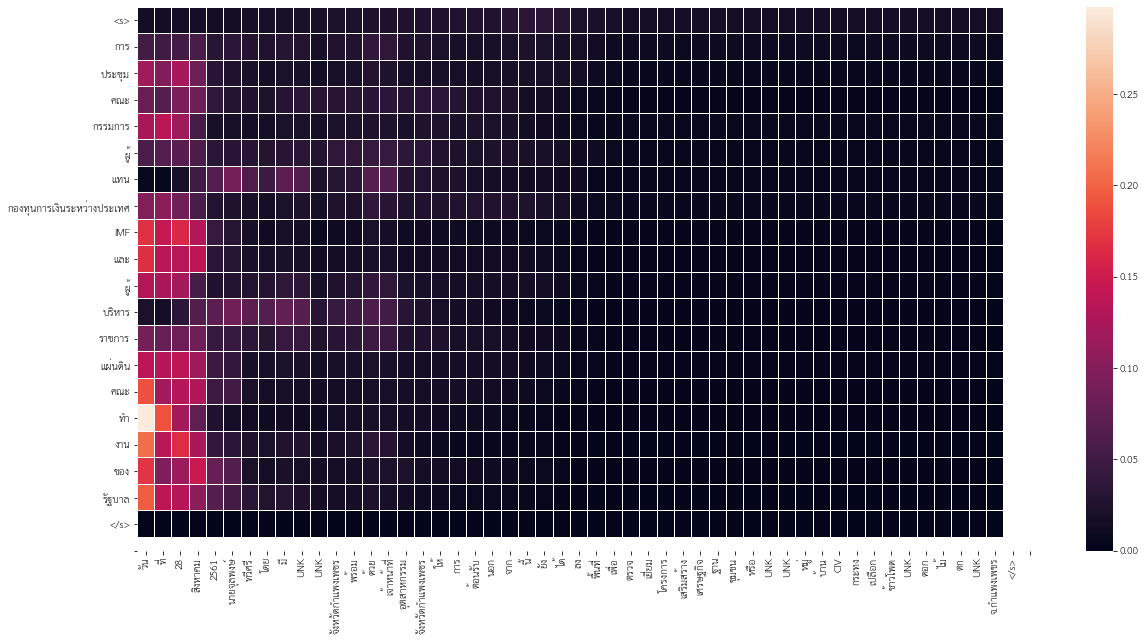

######################################################################################################################################################
headline  :  ยืนยัน ยัง ไม่ มี แนว คิด ปรับ ขึ้น ภาษี VAT วอน สังคม อย่า ตื่นตระหนก และ หลง เชื่อ ย้ำ นายก </s> 
content   :  นี้ 25 พฤษภาคม 2561 พลโท สรรเสริญ แก้วกำเนิด โฆษก ประจำ สำนักนายกรัฐมนตรี กล่าว ถึง กรณี ที่ มี การ แชร์ ข้อความ และ ภาพ ระบุ UNK ประชาชน จ่าย ภาษี มูลค่า เพิ่ม เป็น 8 % ถ้า ไม่ ขึ้น ประเทศ จะ ล้มละลาย ใน ช่วง นี้ ว่า ข้อความ และ ภาพ ดัง กล่าว เป็น เรื่อง เก่า เมื่อ เดือน มี.ค. </s> 
Input: [   17   390   308    25   991    99    50   215    87   110   153     4
    19     1  1637  1300     5   753   617 25312    53   543   354   554
   141     9   222   559  5475   118   127    65   178  1797     6   246
    17    42  1300     5   753   281    87     9   145  1388    62   202
   556     3]
prediction : <s> เผย รัฐบาล ไม่ละเลย การ แก้ไข ปัญหา ฝุ่น ละออง ขนาด เล็ก PM 2 ที่สุด ใน ช่วง ฤดู ฝน ตก หนัก แนะ 


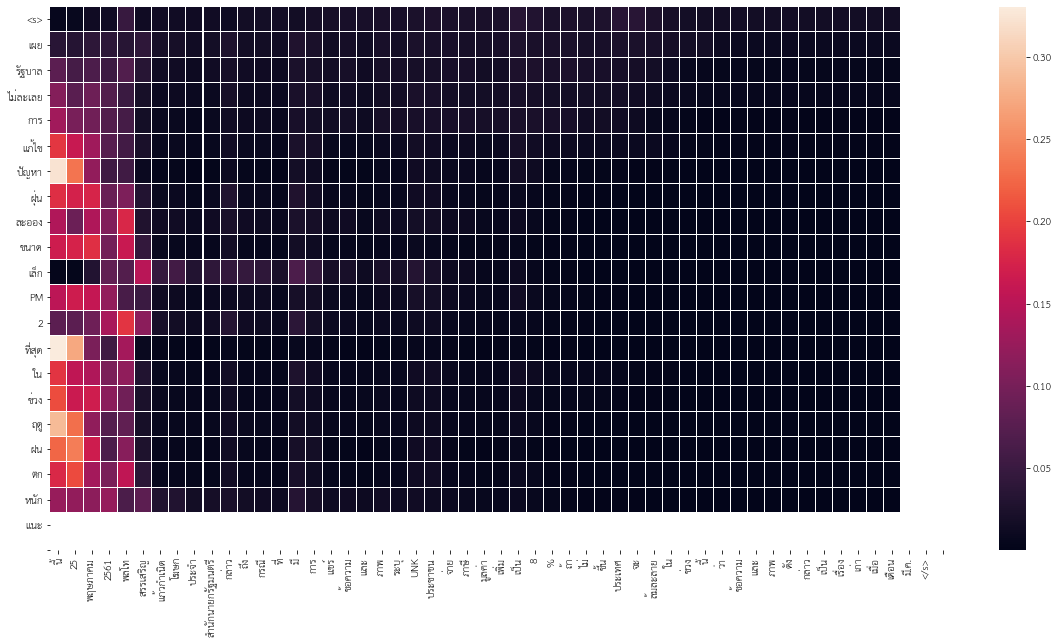

######################################################################################################################################################
headline  :  <s> นโยบาย การ ผลิต ครู ผู้ ช่วย เลือด ใหม่ </s> 
content   :  เปิด โอกาส ให้ ผู้ มี ความ สามารถ ใน หลากหลาย สาขา อาชีพ สามารถ สอบ ครู ผู้ ช่วย ใน สาขา ที่ ขาดแคลน ได้ โดย จะ ฝึกอบรม อย่าง เข้มข้น ก่อน บรรจุ ต่อ จาก นี้ ไป ขอ เชิญ รับฟัง ไทย คู่ฟ้า ครับ จาก นโยบาย ของ รัฐบาล ที่ เปิด โอกาส ให้ ผู้ ไม่ มี </s> 
Input: [  38  136   12   10   19   11  302    6 1633  768  488  302 1162  391
   10   58    6  768    4 1863   23   34  178  639   76 1829  404 1263
   96   41   17   90  157  388  270   36  590  449   41   98   18   57
    4   38  136   12   10  118   19    3]
prediction : <s> กระทรวงเกษตรฯ จัด งาน วัน คุ้มครอง โลก </s> 


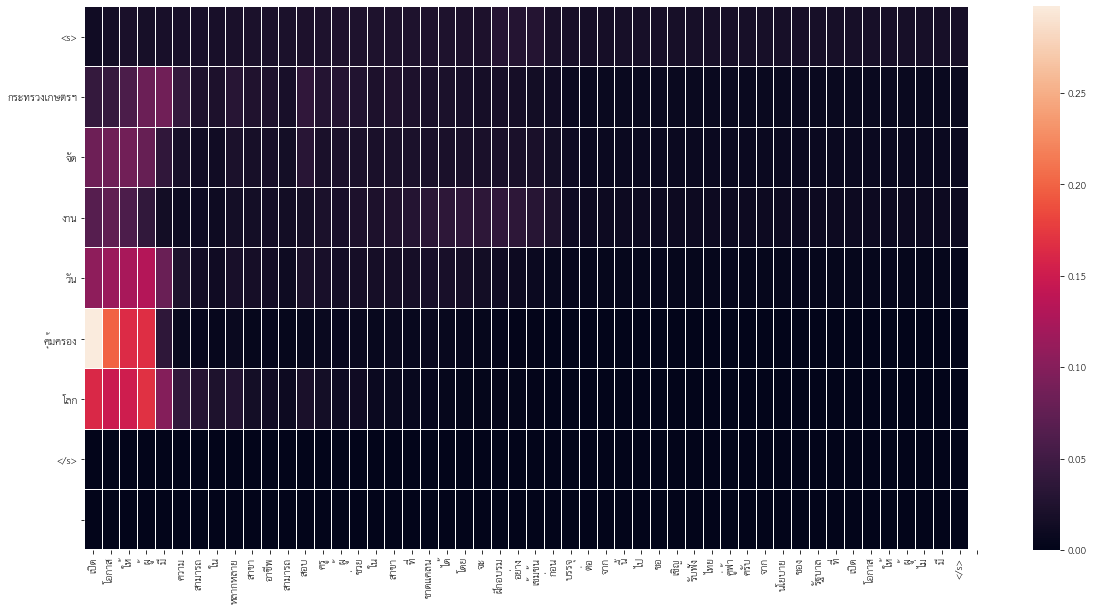

######################################################################################################################################################
headline  :  <s> ปิด งาน ชุมนุม ลูก เสือ จังหวัด ชาย แดน ภาค ใต้ ครั้ง ที่ 12 จังหวัดสตูล </s> 
content   :  รัฐมนตรี ช่วย ว่าการ กระทรวงศึกษาธิการ เป็น ประธาน พิธี ปิด งาน ชุมนุม ลูก เสือ จังหวัด ชาย แดน ภาค ใต้ ครั้ง ที่ 12 ณ ค่าย ลูกเสือปากบาง อำเภอละงู จังหวัดสตูล พล.อ.สุรเชษฐ์ ชัยวงศ์ รมช. ศึกษาธิการ ได้ กล่าว ใน พิธี ปิด ดัง นี้ ท่าน ผู้ บังคับบัญชา ลูกเสือ ลูกเสือ - UNK ที่ เข้า ร่วม ชุมนุม คณะ ลูกเสือ จาก </s> 
Input: [    7    58    22   103     9    21    82   626    13  1724   828  3510
   158   271   430    51   109    54     4   264    26  1564 20511  7945
  3491   585   480   884    23    87     6    82   626   281    17   800
    10  3709  2066  2066    39 25312     4    46    27  1724    32  2066
    41     3]
prediction : <s> ศธ. จัด งาน วัน สถาปนา สำนัก งานเลขาธิการคุรุสภา </s> 


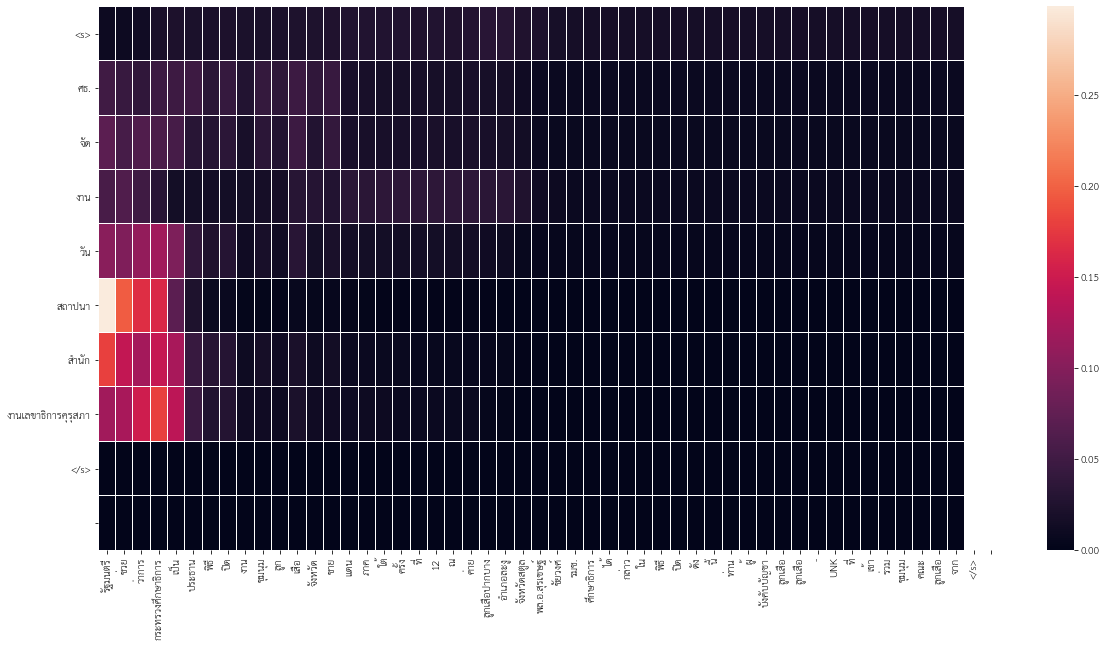

######################################################################################################################################################
headline  :  <s> เตือน นาย จ้าง ห้าม บังคับ ลูกจ้าง ทำ งาน วัน หยุด </s> 
content   :  และ คุ้มครอง แรงงาน เตือน นาย จ้าง ให้ ลูกจ้าง ทำ งาน ใน วัน หยุด ผิด กฎหมาย หาก จำเป็น ต้อง ได้ รับ ความ ยินยอม จาก ลูกจ้าง ก่อน และ ต้อง จ่าย ค่า ทำ งาน ใน วัน หยุด นายอนันต์ชัย อุทัยพัฒนา ชีพ อธิบดี กรมสวัสดิการ และ คุ้มครอง แรงงาน กสร. เปิดเผย ว่า พระราชบัญญัติ คุ้มครอง แรงงาน พ.ศ. 2541 </s> 
Input: [    5   251    88   484   384   330    12   512    79    13     6     8
  1038   418   199   744  1188   265    23    48    11  8692    41   512
   404     5   265   543   237    79    13     6     8  1038   863   566
   190   481     5   251    88   518    67    42   705   251    88   212
 10437     3]
prediction : <s> กสร. เตือน นาย จ้าง อย่า ลืม จัด ซ้อม หนี ไฟ ไหม้ </s> 


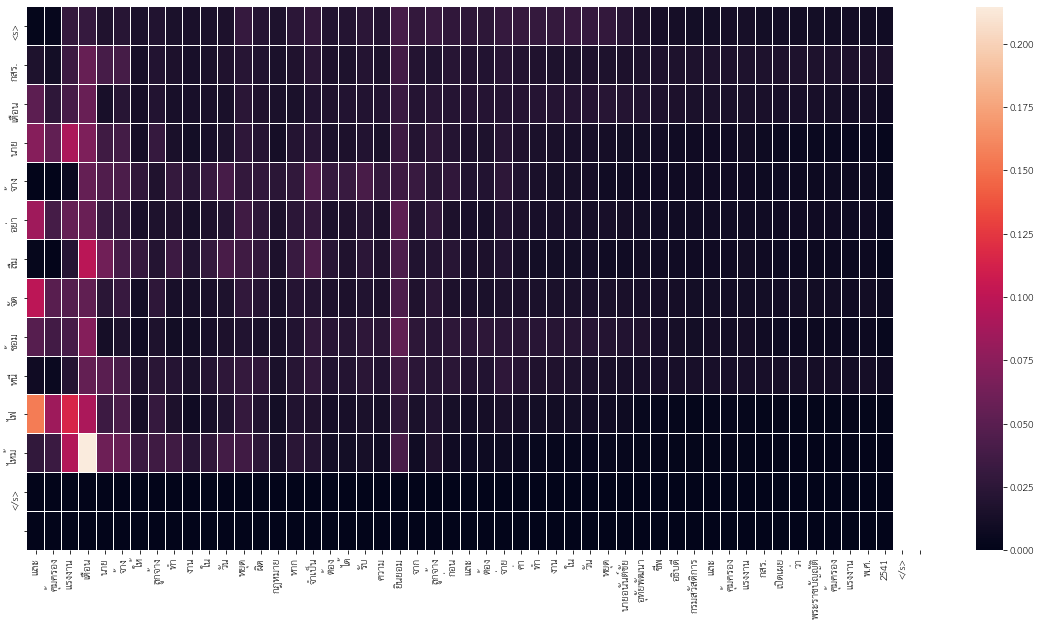

######################################################################################################################################################
headline  :  <s> ฐานะ การ คลัง ของ รัฐบาล ใน ช่วง 8 เดือน แรก ของ ปี งบ ประมาณ 2560 </s> 
content   :  สํานัก งาน เศรษฐกิจการ คลัง ใน ฐานะ โฆษก กระทรวงการคลัง แถลง ข่าว ฐานะ การ คลัง ของ รัฐบาล ตาม ระบบ กระแส เงิน สด ใน ช่วง 8 เดือน แรก ของ ปี งบ ประมาณ 2560 เดือน ตุลาคม 2559 – เดือน พฤษภาคม 2560 นายกฤษฎา  จี นะ วิจารณะ UNK  อํานวยการ สํานัก งาน เศรษฐกิจการ คลัง ใน ฐานะ </s> 
Input: [ 5540    13  1608   415     6   262    99   286   207   179   262     1
   415    18    57    55   113  1127    74   940     6   246   222   202
   363    18    28   240   221    31   202   266   256   227   202   308
    31  5893  3581  1378 25312  4671  5539  5540    13  1608   415     6
   262     3]
prediction : <s> รายงาน ความ คืบหน้า การ คลัง ของ รัฐบาล ใน ช่วง ครึ่ง แรก ของ สำนักงานบริหารหนี้สาธารณะ </s> 


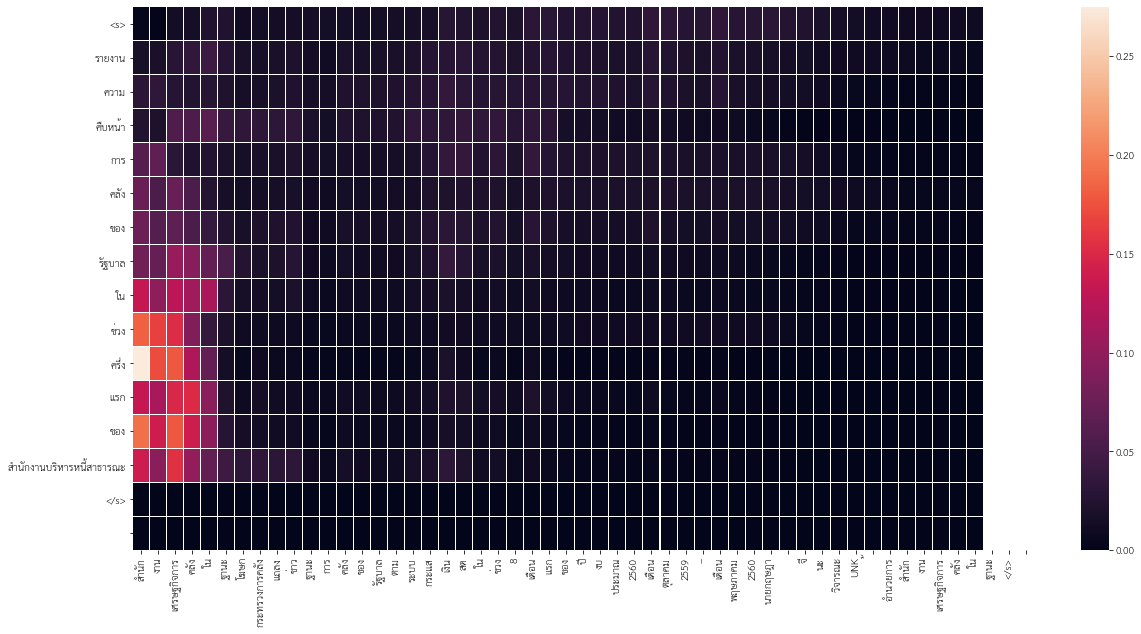

######################################################################################################################################################
headline  :  กำชับ ทีม One Home เร่ง เยียวยา จิตใจ สาว UNK วัย 15 ปี ที่ ถูก ลุง เขย บังคับ ข่มขืน จน </s> 
content   :  นี้ 12 ม.ค. 61 เวลา 08 . 30 น. กระทรวงการพัฒนาสังคมและความมั่นคงของมนุษย์ พม. โดย นายณรงค์ คงคำ รอง ปลัด กระทรวงการพัฒนาสังคมและความมั่นคงของมนุษย์ รอง ปลัด พม. เป็น ประธาน การ ประชุม ศูนย์ ปฏิบัติการ กระทรวงการพัฒนาสังคมและความมั่นคงของมนุษย์ ศปก.พม. ครั้ง ที่ 20 / 2561 เพื่อ รับ ทราบ ปัญหา ทาง สังคม ต่างๆ ที่ เกิด ขึ้น ใน แต่ละ วัน และ ร่วมหา แนวทาง การ </s> 
Input: [  17  264  623  130   24  373   14   66   33  132   97   34  605   30
   37  132   30   37   97    9   21    1   15  151  257  132  730   54
    4  205   68   25   20   48  380   85   52  106  757    4  241  127
    6  792    8    5 1286  180    1    3]
prediction : <s> ทีม One Home เร่ง ช่วยเหลือ ผู้ ด้อย โอกาส และ ประสบ ปัญหา ทาง สังคม ที่ จ.สุรินทร์ พ

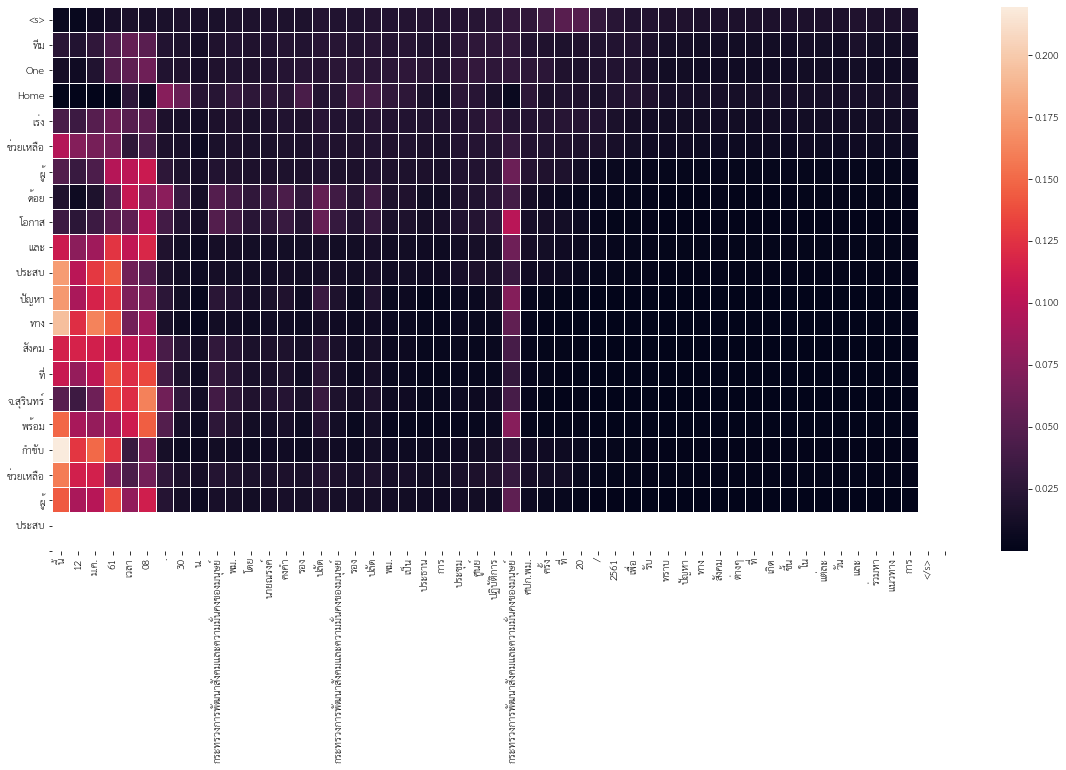

######################################################################################################################################################
headline  :  เชิญชวน ประชาชน ร่วม กิจกรรม สัปดาห์ เผยแผ่ พระพุทธศาสนา เนื่อง ใน เทศกาล วัน มา ฆบูชา ประจำ ปี 2561 ณ พุทธมณฑล 25 </s> 
content   :  การ ประชุม คณะ รัฐมนตรี นายสุวพันธุ์ ตันยุวรรธนะ รมต. นร. ได้ เข้า พบ นายก รัฐมนตรี เพื่อ ประชาสัมพันธ์ ใน การ จัด สัปดาห์ เผยแผ่ พระพุทธศาสนา เนื่อง ใน เทศกาล วัน มาฆบูชา พร้อม ย้ำ ให้ ยึด หลัก คำ สอน ของ พระพุทธเจ้า ใน การ ดำเนิน ชีวิต ประจำ วัน วัน นี้ 20 กุมภาพันธ์ 2561 เวลา 08 . 30 </s> 
Input: [   1   15   32    7  857  698 1457   23   46  250   16    7   20  731
    6    1   43  950 4884 1624  214    6  479    8 2754   29  213   12
  858  292  398 1335   18 6779    6    1   77  193   50    8    8   17
  205  282   25   24  373   14   66    3]
prediction : <s> รมต. นร. ออมสิน ฯ เป็น ประธาน การ ประชุม คณะ กรรมการ ขับเคลื่อน และ เร่งรัด การ ดำเนิน งาน ตาม นโยบาย รัฐบาล กขร. ครั้ง 


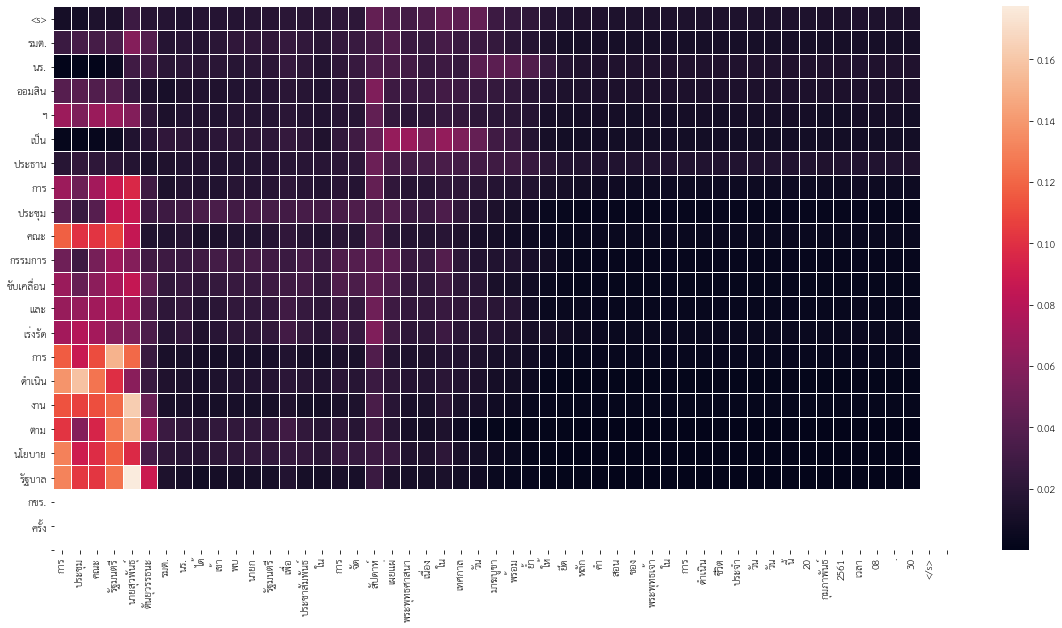

######################################################################################################################################################
headline  :  <s> ไทย และ UNK เจตนารมณ์ ร่วม กัน ใน การ แก้ไข ปัญหา ยา เสพ ติด อาชญากรรม และ การ ทุจริต </s> 
content   :  นี้ วัน จันทร์ ที่ 5 มีนาคม 2561 เวลา 13 . 15 น. นายยูริ เฟโดทอฟ UNK Fedotov ผู้ อำนวย การ บริหาร UNK ด้วย ยา เสพ ติด และ UNK UNODC และ รอง เลขาธิการ สหประชาชาติ เข้า เยี่ยม คารวะ พลอากาศ เอก  ประจิน จั่นตอง รอง นายก รัฐมนตรี และ รัฐมนตรี ว่าการ กระทรวงยุติธรรม ณ ห้อง รับรอง 1 ตึกบัญชา </s> 
Input: [   17     8   507     4   117   236    25    24   134    14   163    33
  6589 25312  8200    10   167     1    89 25312    64   394   622   385
     5 25312  4235     5    30   226  1848    46   104   295   591   361
   477    30    16     7     5     7    22    70    26    75   471    49
   555     3]
prediction : <s> รัฐมนตรี ว่าการ กระทรวงยุติธรรม ให้ การ ต้อนรับ เอกอัครราชทูต แคนาดา ประจำ ประเทศไทย เข้า เยี่ยม คารวะ น

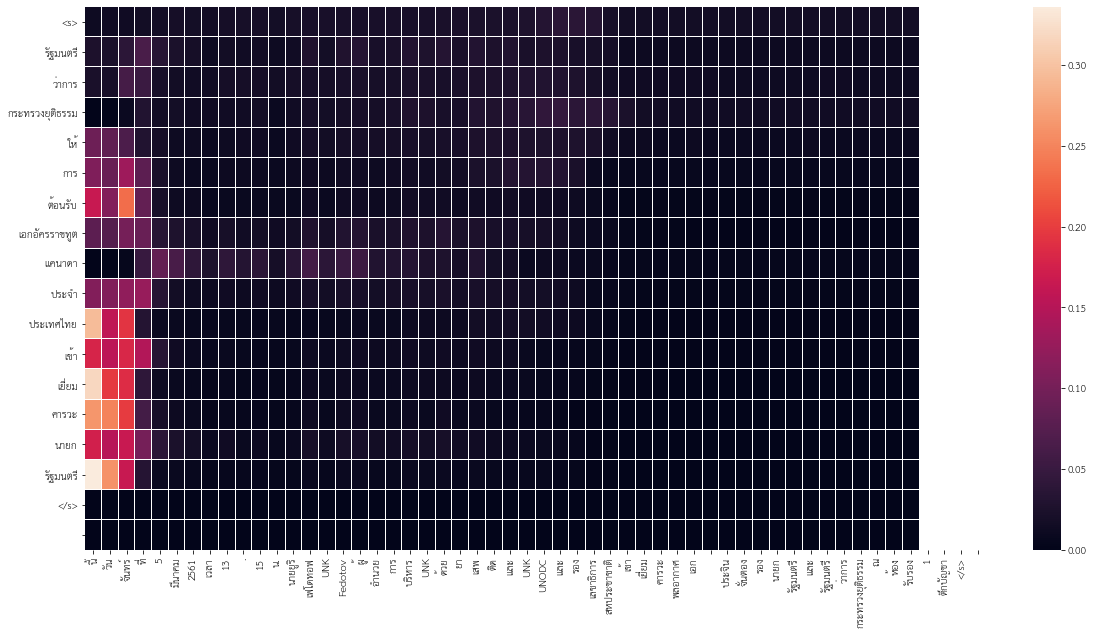

######################################################################################################################################################


In [0]:
for i in range(10):
  print('headline  : ',index2sentence(y_test[i]))
  print('content   : ',index2sentence(X_test[i]))
  translate(X_test[i])
  print( '#' * 150)

In [0]:
encoder.summary()

Model: "encoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      multiple                  6480128   
_________________________________________________________________
gru_6 (GRU)                  multiple                  3938304   
Total params: 10,418,432
Trainable params: 10,418,432
Non-trainable params: 0
_________________________________________________________________


In [0]:
decoder.summary()

Model: "decoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      multiple                  6480128   
_________________________________________________________________
gru_7 (GRU)                  multiple                  7084032   
_________________________________________________________________
dense_24 (Dense)             multiple                  25945825  
_________________________________________________________________
bahdanau_attention_7 (Bahdan multiple                  2100225   
Total params: 41,610,210
Trainable params: 41,610,210
Non-trainable params: 0
_________________________________________________________________


# Evaluation

In [0]:
!pip install rouge

In [0]:
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

# Result

In [0]:
# scheduled sampling with stopwords v2
from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Eval train : {'rouge-1': {'f': 0.3316216664676006, 'p': 0.39584552756168767, 'r': 0.3043822771264748}, 'rouge-2': {'f': 0.14539594442405668, 'p': 0.16653982639058618, 'r': 0.13704949243104267}, 'rouge-l': {'f': 0.3411716701418495, 'p': 0.4265433187135071, 'r': 0.302346349912178}}
Eval val   : {'rouge-1': {'f': 0.2753238649040949, 'p': 0.3312370714680459, 'r': 0.2523167631232138}, 'rouge-2': {'f': 0.09332359440670134, 'p': 0.10657701641468456, 'r': 0.0877801989930994}, 'rouge-l': {'f': 0.2842083111855991, 'p': 0.35679757437524784, 'r': 0.2516226344043467}}
Eval test  : {'rouge-1': {'f': 0.2772315095364518, 'p': 0.332982683027399, 'r': 0.25433679121886066}, 'rouge-2': {'f': 0.09368943296864761, 'p': 0.10680276491684366, 'r': 0.08852816663196328}, 'rouge-l': {'f': 0.2846344066931298, 'p': 0.3562378807841689, 'r': 0.25295440473734976}}


In [0]:
# teacher forcing with stopwords v2 (cleaned and resplitted)

from tqdm import tqdm_notebook
from rouge import Rouge
def inference(dataset) :
  pred_sum = []
  for c in tqdm_notebook(dataset):
    pred_sum.append(translate(c, plot=False))
  return pred_sum
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 

y_train_pred = inference(X_train)
y_val_pred = inference(X_val)
y_test_pred = inference(X_test)

print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



Eval train : {'rouge-1': {'f': 0.31255606618074416, 'p': 0.3699522595639823, 'r': 0.29118707247256176}, 'rouge-2': {'f': 0.13921053678939652, 'p': 0.15919970804256284, 'r': 0.1329544137673485}, 'rouge-l': {'f': 0.3252717405570767, 'p': 0.412626343182596, 'r': 0.28984010064706206}}
Eval val   : {'rouge-1': {'f': 0.26077731568818086, 'p': 0.3138555705697845, 'r': 0.24185617029094433}, 'rouge-2': {'f': 0.0878659722637187, 'p': 0.10085893141122382, 'r': 0.08389562453305079}, 'rouge-l': {'f': 0.2712526981536289, 'p': 0.35058526743159263, 'r': 0.24076205725434838}}
Eval test  : {'rouge-1': {'f': 0.25838712445233686, 'p': 0.31063618231042167, 'r': 0.2405915591012182}, 'rouge-2': {'f': 0.08814604824395639, 'p': 0.10113048852663067, 'r': 0.08452106747164245}, 'rouge-l': {'f': 0.2697474693034942, 'p': 0.3499145752717843, 'r': 0.23965010689122512}}


In [0]:
# teacher forcing with stopwords v1 (cleaned and not resplitted)
from rouge import Rouge
def evaluate_result(gold_sum,pred_sum) : 
  rouge = Rouge()
  avg_scores = rouge.get_scores(pred_sum, gold_sum, avg=True)
  return avg_scores 
print('Eval train :', evaluate_result(gold_sum_train, y_train_pred))
print('Eval val   :', evaluate_result(gold_sum_val, y_val_pred))
print('Eval test  :', evaluate_result(gold_sum_test, y_test_pred))


Eval train : {'rouge-1': {'f': 0.2795673425761507, 'p': 0.3557595652463653, 'r': 0.25352607870171523}, 'rouge-2': {'f': 0.09932441987108667, 'p': 0.12613012960819406, 'r': 0.09226585948787162}, 'rouge-l': {'f': 0.28737431689730497, 'p': 0.3731399927570879, 'r': 0.25371851798119666}}
Eval val   : {'rouge-1': {'f': 0.25329514942133546, 'p': 0.3274296069330234, 'r': 0.22779928431398458}, 'rouge-2': {'f': 0.07118651085296651, 'p': 0.09311496548861718, 'r': 0.06528372785626006}, 'rouge-l': {'f': 0.26002256056456724, 'p': 0.3417097761580575, 'r': 0.2282872326099331}}
Eval test  : {'rouge-1': {'f': 0.25344063948426654, 'p': 0.32598460418102326, 'r': 0.22866659593474578}, 'rouge-2': {'f': 0.07427264694055888, 'p': 0.09647897270043032, 'r': 0.06867201271640855}, 'rouge-l': {'f': 0.2606687205468006, 'p': 0.34019529076833227, 'r': 0.2298648872657804}}


# sth


In [0]:
text = '“ยุติธรรม” เตรียมความพร้อมร่วมกับองค์กรปกครองส่วนท้องถิ่น เพื่อส่งเสริมการดำเนินงานของศูนย์ยุติธรรมชุมชน\
กระทรวงยุติธรรม เตรียมความพร้อมร่วมกับองค์กรปกครองส่วนท้องถิ่น เพื่อส่งเสริมการดำเนินงานของศูนย์ยุติธรรมชุมชน\
ในวันพฤหัสบดีที่ ๒๗ กันยายน ๒๕๖๑ เวลา ๐๙.๐๐ น.\
นางกรรณิการ์ แสงทอง รองปลัดกระทรวงยุติธรรม\
เป็นประธานการประชุมเชิงปฏิบัติการ\
โครงการวิจัยศักยภาพและความพร้อมขององค์กรปกครองส่วนท้องถิ่น\
ในการส่งเสริมการดำเนินงานศูนย์ยุติธรรมชุมชน : กิจกรรมของหน่วยงานที่เกี่ยวข้อง ครั้งที่ ๑\
เพื่อแลกเปลี่ยนความคิดเห็นในการศึกษาศักยภาพและความพร้อมขององค์กรปกครองส่วนท้องถิ่น\
ในการดำเนินงานศูนย์ยุติธรรมชุมชนและศึกษาความต้องการของชุมชน\
ในการดำเนินงานยุติธรรมชุมชนในพื้นที่โดยมีผู้แทนจากหน่วยงานที่เกี่ยวข้อง เข้าร่วมประชุมฯ\
ณ โรงแรม อมารี ดอนเมือง แอร์พอร์ต กรุงเทพฯ\
รองปลัดกระทรวงยุติธรรม กล่าวว่า กระทรวงยุติธรรม มีนโยบายให้มีการบูรณาการ\
การทำงานของส่วนราชการในสังกัด ทั้งในส่วนกลางและระดับจังหวัด\
เน้นบทบาทหน้าที่ของสำนักงานยุติธรรมจังหวัด และศูนย์ยุติธรรมชุมชน\
โดยประสานงานกับศูนย์ดำรงธรรม และหน่วยงานอื่นๆ ที่เกี่ยวข้อง\
เพื่ออำนวยความยุติธรรม ลดความเหลื่อมล้ำ ให้แก่ประชาชนระดับพื้นที่\
อาทิ การสร้างการรับรู้ด้านกฎหมายในชีวิตประจำวัน การให้คำปรึกษาด้านกฎหมาย\
การทำให้ประชาชนเข้าถึงงานบริการของกองทุนยุติธรรม การช่วยเหลือเยียวยาประชาชนที่ถูกละเมิดสิทธิ\
การสร้างมาตรการไกล่เกลี่ยระงับข้อพิพาทให้เกิดขึ้นในชุมชน การคุ้มครองพยาน\
และการคืนคนดีสู่สังคม เป็นต้น\
ดังนั้น การศึกษาความต้องการของประชาชนในระดับพื้นที่ และการดำเนินงาน\
ร่วมกับหน่วยงานที่เกี่ยวข้องในระดับพื้นที่จึงมีความจำเป็นอย่างมาก\
ซึ่งโครงการศึกษาฯ ดังกล่าว จะทำให้ได้ข้อมูลรูปแบบความต้องการของประชาชน\
และปัจจัยที่ช่วยส่งเสริมการดำเนินงานของศูนย์ยุติธรรมชุมชน\
อันจะนำไปสู่การสังเคราะห์แนวทาง วิธีการดำเนินงานขององค์กรปกครองส่วนท้องถิ่น\
ในการบริหารจัดการศูนย์ยุติธรรมชุมชนอย่างเป็นรูปธรรม ต่อไป\
                            '
  
                          

AttributeError: ignored

In [0]:
translate(u'¿todavia estan en casa?')

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<s> ' + w + ' </s>'
  return w